In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
import random
import json
import csv
import os
import pickle

# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *Y*

**Names:**

* *Kristian Aurlien*
* *Mateusz Paluchowski*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

#### 1: Simulation of the plage over 100 days

In [3]:
import epidemics_helper

In [4]:
# Load raw data from json
with open('../data/nyc_augmented_network.json') as data_file:    
    data = json.load(data_file)

In [5]:
# Create graph from loaded data
from networkx.readwrite import json_graph

G = json_graph.node_link_graph(data)

In [6]:
#Create epidemics SIR simulator
sir = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1)

In [7]:
# Launch simulation
sir.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 108.30 days | 108.30 days elapsed | 0.0% susceptible, 0.0% infected, 99.9% recovered


In [8]:
# Let's get some info on patient zero:
print('Infection time: ', sir.inf_time[0])
print('Recovery time: ', sir.rec_time[0])

Infection time:  5.53224582219
Recovery time:  18.1620984595


#### 2. Plots of the epidemic over time

In [8]:
infected = np.asarray([len([x for x in sir.inf_time if x <= i])* 100. / sir.n_nodes for i in range(100)])
recovered = np.asarray([len([x for x in sir.rec_time if x <= i])* 100. / sir.n_nodes for i in range(100)])
susceptible = np.asarray([100 - infected[i] - recovered[i] for i in range(100)])

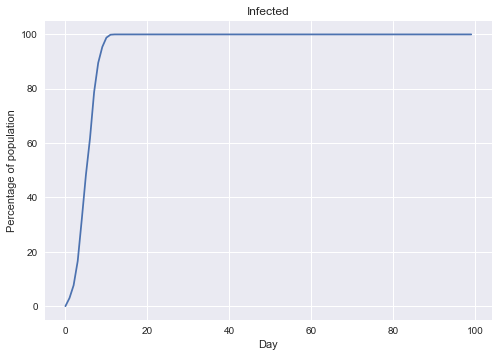

In [9]:
plt.plot(infected)
plt.title('Infected')
plt.ylabel("Percentage of population")
plt.xlabel("Day")
plt.show()

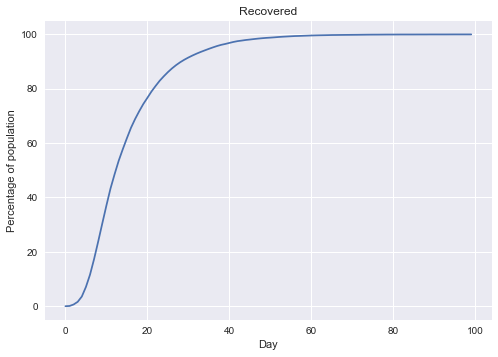

In [10]:
plt.plot(recovered)
plt.title('Recovered')
plt.ylabel("Percentage of population")
plt.xlabel("Day")
plt.show()

In [10]:
def epidemic_evolution(sir):
    stat_susceptible = []
    stat_infected = []
    stat_recovered = []

    for i in range(100):
        cum_infected = np.where(sir.inf_time <= i)

        recovered = np.where(sir.rec_time <= i)
        stat_recovered.append(recovered[0])

        infected = np.setdiff1d(cum_infected, recovered)
        stat_infected.append(infected)

        susceptible = np.setdiff1d(np.asarray(sir.G.nodes()), cum_infected)
        stat_susceptible.append(susceptible)

    stat_susceptible = np.asarray(stat_susceptible)
    stat_infected = np.asarray(stat_infected)
    stat_recovered = np.asarray(stat_recovered)    

    # Normalize the statistics    
    plot_s = np.asarray([len(x) for x in stat_susceptible]) * 100.  / sir.n_nodes
    plot_i = np.asarray([len(x) for x in stat_infected]) * 100. / sir.n_nodes
    plot_r = np.asarray([len(x) for x in stat_recovered]) * 100.  / sir.n_nodes

    return (plot_s, plot_i, plot_r), (stat_susceptible, stat_infected, stat_recovered)

In [11]:
plot_sir, stats_sir, = epidemic_evolution(sir)

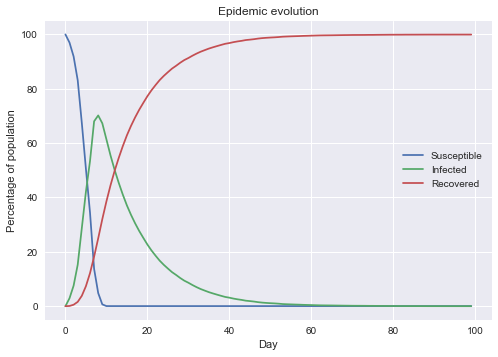

Statistics after 30 days: 
Healthy:  0.045315509233
Infected:  9.39919187342
Dead:  90.5554926173


In [12]:
def plot_SIR(plot_sir, title='Epidemic evolution'):
    plt.plot(plot_sir[0])
    plt.plot(plot_sir[1])
    plt.plot(plot_sir[2])
    plt.title(title)
    plt.legend(['Susceptible', 'Infected', 'Recovered'])
    plt.ylabel("Percentage of population")
    plt.xlabel("Day")
    plt.show()
    
    print('Statistics after 30 days: ')
    print('Healthy: ',plot_sir[0][29])
    print('Infected: ',plot_sir[1][29])
    print('Dead: ', plot_sir[2][29])
    
plot_SIR(plot_sir)

We can se that the number of susceptible people drastically quickly frecreases, while the number of infected incrreases. After a short while, as people start to recover, the percentage of infected people goes down again.

#### 3: How long does it take before 60% of the population is infected?

In [13]:
print("After {} days, 60% are infected.".format(np.min(np.where(plot_sir[1] > 60))))

After 7 days, 60% are infected.


In [15]:
print("After {} days, 60% are dead.".format(np.min(np.where(plot_sir[2] > 60))))

After 15 days, 60% are dead.


### Visualization of coordinates:

In [16]:
def convert_coordinate(coord):
    return [coord[1] / 1e6, coord[0] / 1e6]

def split_coordinates(coords):
    x = [c[0] for c in coords]
    y = [c[1] for c in coords]
    
    return x, y

def get_coordinates(stats, day):
    coords = [G.node[n]['coordinates'] for n in stats[day]]

    converted = [convert_coordinate(coord) for coord in coords]
    x, y = split_coordinates(converted)
    
    return x, y

In [17]:
def visualize_spread(stats_sir, day):
    x_s, y_s = get_coordinates(stats_sir[0], day)
    x_i, y_i = get_coordinates(stats_sir[1], day)
    x_r, y_r = get_coordinates(stats_sir[2], day)

    plt.scatter(x_s, y_s, c='g')
    plt.scatter(x_i, y_i, c='b')
    plt.scatter(x_r, y_r, c='r')
    

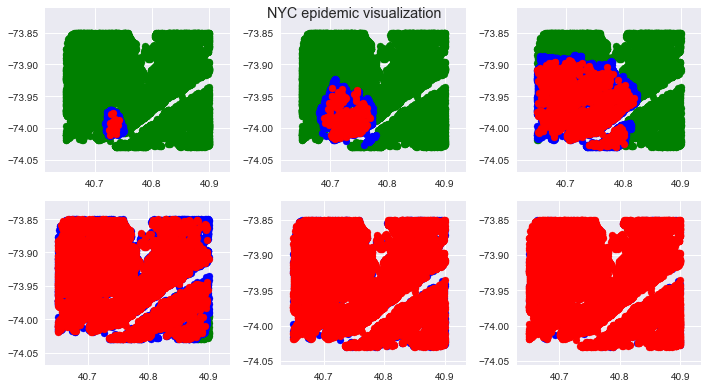

In [18]:
plt.figure(figsize=(10,8))
plt.subplot(331)
visualize_spread(stats_sir, 1)
plt.subplot(332)
visualize_spread(stats_sir, 3)
plt.subplot(333)
visualize_spread(stats_sir, 5)
plt.subplot(334)
visualize_spread(stats_sir, 10)
plt.subplot(335)
visualize_spread(stats_sir, 20)
plt.subplot(336)
visualize_spread(stats_sir, 30)
plt.tight_layout()
plt.suptitle('NYC epidemic visualization')
plt.show()

In the top left corner, we see the spread after 1 day, top-middle 3 days, and top right corner 5 days. In the bottom row, we see spread after 10, 20, and 30 days. 

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [19]:
G1 = G.copy()

In [20]:
def drop_random_edges(graph, no_of_edges):
    G = graph.copy()
    edges = G.edges()
    random.shuffle(edges)
    to_delete = edges[:no_of_edges]

    for edge in to_delete:
        G.remove_edge(*edge)
    return G

In [21]:
G1 = drop_random_edges(G, 1000)

In [22]:
def multi_simulate(G1, number_of_simulations):
    sir = epidemics_helper.SimulationSIR(G1, beta=10.0, gamma=0.1)
    S_agg = np.zeros(100)
    I_agg = np.zeros(100)
    R_agg = np.zeros(100)
    for i in range(number_of_simulations):
        print('Simulation no: ', i)
        rand_source = random.randint(0, G1.number_of_nodes())
        sir.launch_epidemic(source=rand_source, max_time=100.0)
        plot_sir, stats_sir = epidemic_evolution(sir)

        S_agg += plot_sir[0]
        I_agg += plot_sir[1]
        R_agg += plot_sir[2]

    S_agg /= 10
    I_agg /= 10
    R_agg /= 10
    
    return (S_agg, I_agg, R_agg)

In [23]:
# Simulate 10 times
SIR_agg = multi_simulate(G1 , 10)

Simulation no:  0
Epidemic stopped after 100.38 days | 100.38 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Simulation no:  1
Epidemic stopped after 101.22 days | 101.22 days elapsed | 0.2% susceptible, 0.0% infected, 99.7% recovered
Simulation no:  2
Epidemic stopped after 100.63 days | 100.63 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  3
Epidemic stopped after 101.35 days | 101.35 days elapsed | 0.3% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  4
Epidemic stopped after 103.35 days | 103.35 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Simulation no:  5
Epidemic stopped after 101.70 days | 101.70 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  6
Epidemic stopped after 101.05 days | 101.05 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Simulation no:  7
Epidemic stopped after 100.92 days | 100.92 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% re

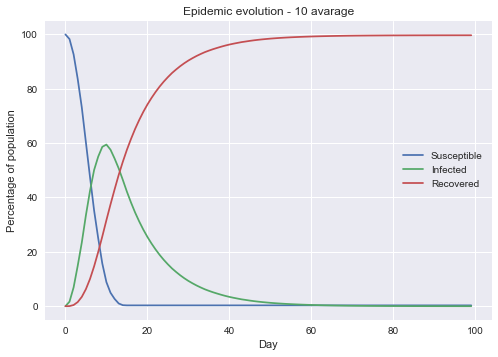

Statistics after 30 days: 
Healthy:  0.308523092028
Infected:  10.293040293
Dead:  89.3984366149


In [24]:
plot_SIR(SIR_agg, 'Epidemic evolution - 10 avarage')

#### What happens if you increase the budget (e.g. to 10000 edges)?

In [25]:
G1 = drop_random_edges(G, 10000)

In [26]:
# Simulate 10 times
SIR_agg = multi_simulate(G1 , 10)

Simulation no:  0
Epidemic stopped after 122.72 days | 122.72 days elapsed | 67.1% susceptible, 0.0% infected, 32.9% recovered
Simulation no:  1
Epidemic stopped after 94.55 days | 94.55 days elapsed | 57.4% susceptible, 0.0% infected, 42.6% recovered
Simulation no:  2
Epidemic stopped after 91.03 days | 91.03 days elapsed | 67.1% susceptible, 0.0% infected, 32.9% recovered
Simulation no:  3
Epidemic stopped after 107.07 days | 107.07 days elapsed | 57.3% susceptible, 0.0% infected, 42.7% recovered
Simulation no:  4
Epidemic stopped after 96.17 days | 96.17 days elapsed | 57.4% susceptible, 0.0% infected, 42.6% recovered
Simulation no:  5
Epidemic stopped after 87.72 days | 87.72 days elapsed | 87.2% susceptible, 0.0% infected, 12.8% recovered
Simulation no:  6
Epidemic stopped after 101.61 days | 101.61 days elapsed | 67.0% susceptible, 0.0% infected, 33.0% recovered
Simulation no:  7
Epidemic stopped after 105.96 days | 105.96 days elapsed | 67.1% susceptible, 0.0% infected, 32.9% re

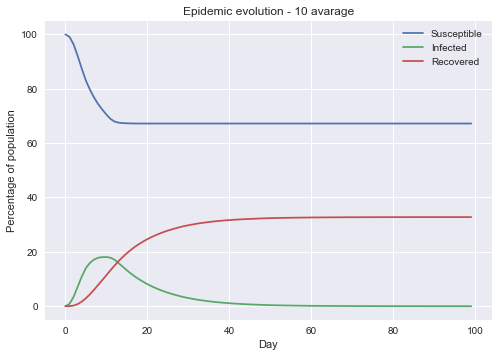

Statistics after 30 days: 
Healthy:  67.2115856652
Infected:  3.30501114006
Dead:  29.4834031947


In [27]:
plot_SIR(SIR_agg, 'Epidemic evolution - 10 avarage')

#### Exercise 2.11: Strategy 2

In [28]:
def clever_edge_drop(graph, no_of_edges):
    G = graph.copy()
    edges = G.edges()
    random.shuffle(edges)
    rand_edges = edges[:no_of_edges]
    
    for edge in rand_edges:
        node1, node2  = edge
        if nx.degree(G, node1) > nx.degree(G, node2):
            popular_edges = G.edges(node1)
        else:
            popular_edges = G.edges(node2)
        random.shuffle(popular_edges)
        G.remove_edge(*popular_edges[0])
    return G

In [29]:
G2 = clever_edge_drop(G, 2500)

In [30]:
# Simulate 10 times
SIR_agg = multi_simulate(G2 , 10)

Simulation no:  0
Epidemic stopped after 100.93 days | 100.93 days elapsed | 0.8% susceptible, 0.0% infected, 99.2% recovered
Simulation no:  1
Epidemic stopped after 111.48 days | 111.48 days elapsed | 0.8% susceptible, 0.0% infected, 99.2% recovered
Simulation no:  2
Epidemic stopped after 101.35 days | 101.35 days elapsed | 0.8% susceptible, 0.0% infected, 99.2% recovered
Simulation no:  3
Epidemic stopped after 96.50 days | 96.50 days elapsed | 20.3% susceptible, 0.0% infected, 79.7% recovered
Simulation no:  4
Epidemic stopped after 100.98 days | 100.98 days elapsed | 20.3% susceptible, 0.0% infected, 79.7% recovered
Simulation no:  5
Epidemic stopped after 110.50 days | 110.50 days elapsed | 0.7% susceptible, 0.0% infected, 99.2% recovered
Simulation no:  6
Epidemic stopped after 101.99 days | 101.99 days elapsed | 0.9% susceptible, 0.0% infected, 99.1% recovered
Simulation no:  7
Epidemic stopped after 100.83 days | 100.83 days elapsed | 0.9% susceptible, 0.0% infected, 99.1% re

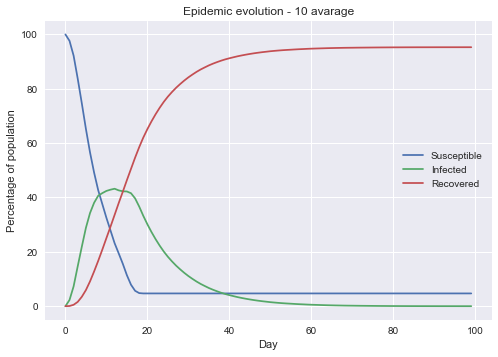

Statistics after 30 days: 
Healthy:  4.7029945999
Infected:  12.2687964956
Dead:  83.0282089045


In [31]:
plot_SIR(SIR_agg, 'Epidemic evolution - 10 avarage')

#### Strategy 2.1

In [32]:
from operator import itemgetter

def isolate_known_people(graph, no_of_edges):
    G = graph.copy()
    known_people = sorted(G.degree_iter(),key=itemgetter(1),reverse=True)
    
    i = 0
    for people in known_people:
        i += people[1]
        to_remove = G.edges(people[0])
        G.remove_edges_from(to_remove)
        
        if i>= no_of_edges:
            break
    return G

In [33]:
G3 = isolate_known_people(G, 2500)

In [34]:
SIR_agg = multi_simulate(G3 , 10)

Simulation no:  0
Epidemic stopped after 101.55 days | 101.55 days elapsed | 2.4% susceptible, 0.0% infected, 97.6% recovered
Simulation no:  1
Epidemic stopped after 104.50 days | 104.50 days elapsed | 2.4% susceptible, 0.0% infected, 97.6% recovered
Simulation no:  2
Epidemic stopped after 98.20 days | 98.20 days elapsed | 2.3% susceptible, 0.0% infected, 97.7% recovered
Simulation no:  3
Epidemic stopped after 101.07 days | 101.07 days elapsed | 2.3% susceptible, 0.0% infected, 97.7% recovered
Simulation no:  4
Epidemic stopped after 101.12 days | 101.12 days elapsed | 2.3% susceptible, 0.0% infected, 97.6% recovered
Simulation no:  5
Epidemic stopped after 99.96 days | 99.96 days elapsed | 22.1% susceptible, 0.0% infected, 77.9% recovered
Simulation no:  6
Epidemic stopped after 113.25 days | 113.25 days elapsed | 2.2% susceptible, 0.0% infected, 97.7% recovered
Simulation no:  7
Epidemic stopped after 104.86 days | 104.86 days elapsed | 2.6% susceptible, 0.0% infected, 97.4% recov

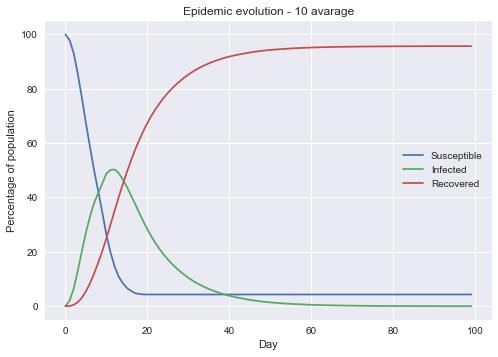

Statistics after 30 days: 
Healthy:  4.31365884974
Infected:  11.5705600242
Dead:  84.1157811261


In [35]:
plot_SIR(SIR_agg, 'Epidemic evolution - 10 avarage')

In [36]:
rand_source = random.randint(0, G.number_of_nodes())
rand_finish = random.randint(0, G.number_of_nodes())

graphs = list(nx.connected_component_subgraphs(G))

#### Strategy 2.2

In [37]:
articulation_nodes = list(nx.articulation_points(G))

In [38]:
len(articulation_nodes)

1866

In [39]:
G4 = G.copy()

In [40]:
i = 0
for node in articulation_nodes:
    to_remove = G4.edges(node)
    i += len(to_remove)
    G4.remove_edges_from(to_remove)

In [41]:
SIR_agg = multi_simulate(G4, 10)

Simulation no:  0
Epidemic stopped after 92.03 days | 92.03 days elapsed | 86.1% susceptible, 0.0% infected, 13.9% recovered
Simulation no:  1
Epidemic stopped after 106.18 days | 106.18 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  2
Epidemic stopped after 126.09 days | 126.09 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  3
Epidemic stopped after 102.37 days | 102.37 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  4
Epidemic stopped after 104.24 days | 104.24 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  5
Epidemic stopped after 112.10 days | 112.10 days elapsed | 26.9% susceptible, 0.0% infected, 73.1% recovered
Simulation no:  6
Epidemic stopped after 108.34 days | 108.34 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  7
Epidemic stopped after 101.71 days | 101.71 days elapsed | 26.8% susceptible, 0.0% infected, 73

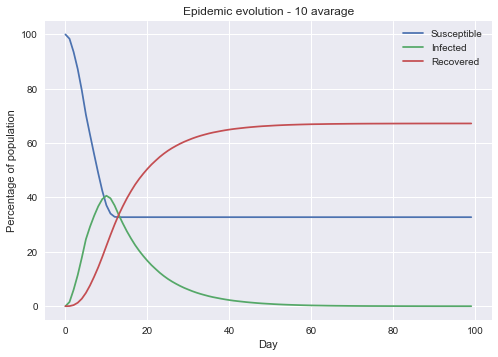

Statistics after 30 days: 
Healthy:  32.7597145123
Infected:  6.73048600884
Dead:  60.5097994789


In [42]:
plot_SIR(SIR_agg, 'Epidemic evolution - 10 avarage')

#### Strategy 2.3

In [43]:
def separate_components(graph, no_of_edges):
    G = graph.copy()
    dropped_edges = 0
    while dropped_edges< no_of_edges:
        nodes = G.nodes()
        random.shuffle(nodes)

        source = nodes[0]
        target = nodes[1]
        
        to_drop = nx.minimum_edge_cut(G, source, target)
        G.remove_edges_from(to_drop)
        dropped_edges += len(to_drop)
    return G

In [44]:
# Takes 30min to complete
# G5 = separate_components(G, 2500) 

In [45]:
# pickle.dump(G5, open("g5.p", "wb"))
G5 = pickle.load( open( "g5.p", "rb" ) )

In [46]:
SIR_agg = multi_simulate(G5, 10)

Simulation no:  0
Epidemic stopped after 96.92 days | 96.92 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Simulation no:  1
Epidemic stopped after 126.83 days | 126.83 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Simulation no:  2
Epidemic stopped after 102.22 days | 102.22 days elapsed | 67.1% susceptible, 0.0% infected, 32.9% recovered
Simulation no:  3
Epidemic stopped after 102.47 days | 102.47 days elapsed | 58.2% susceptible, 0.0% infected, 41.8% recovered
Simulation no:  4
Epidemic stopped after 107.95 days | 107.95 days elapsed | 82.4% susceptible, 0.0% infected, 17.6% recovered
Simulation no:  5
Epidemic stopped after 106.69 days | 106.69 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Simulation no:  6
Epidemic stopped after 95.34 days | 95.34 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Simulation no:  7
Epidemic stopped after 97.44 days | 97.44 days elapsed | 82.4% susceptible, 0.0% infected, 17.6% 

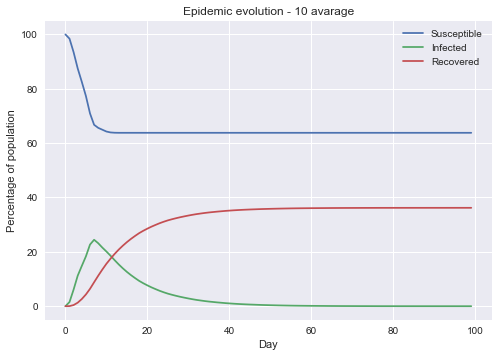

Statistics after 30 days: 
Healthy:  63.796306786
Infected:  3.15056077943
Dead:  33.0531324346


In [47]:
plot_SIR(SIR_agg, 'Epidemic evolution - 10 avarage')

#### Strategy 2.4

In [48]:
G6 = G.copy()

In [49]:
# from networkx.algorithms.flow import shortest_augmenting_path
# cutsets = list(nx.all_node_cuts(G6, flow_func=shortest_augmenting_path)) # takes 3h to complete

In [50]:
# pickle.dump(cutsets, open("cutsets.p", "wb"))
cutsets = pickle.load( open( "cutsets.p", "rb" ) )

In [51]:
cutsets_list = [list(cut) for cut in cutsets]
cutsets_list = sum(cutsets_list, [])

In [52]:
to_remove = G6.edges(cutsets_list)
len(to_remove)

4878

In [53]:
G6.remove_edges_from(to_remove)

In [54]:
SIR_agg = multi_simulate(G6, 10)

Simulation no:  0
Epidemic stopped after 102.64 days | 102.64 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  1
Epidemic stopped after 101.76 days | 101.76 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  2
Epidemic stopped after 102.59 days | 102.59 days elapsed | 26.9% susceptible, 0.0% infected, 73.1% recovered
Simulation no:  3
Epidemic stopped after 16.33 days | 16.33 days elapsed | 100.0% susceptible, 0.0% infected, 0.0% recovered
Simulation no:  4
Epidemic stopped after 105.66 days | 105.66 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  5
Epidemic stopped after 100.41 days | 100.41 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  6
Epidemic stopped after 97.67 days | 97.67 days elapsed | 86.1% susceptible, 0.0% infected, 13.9% recovered
Simulation no:  7
Epidemic stopped after 102.85 days | 102.85 days elapsed | 86.2% susceptible, 0.0% infected, 13.8

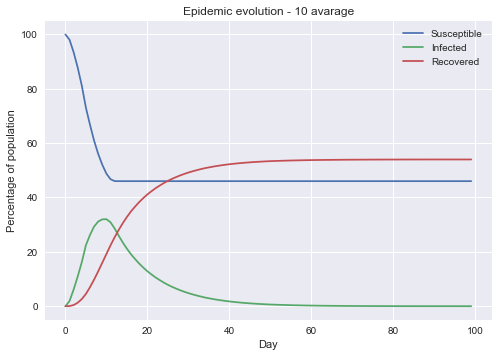

Statistics after 30 days: 
Healthy:  46.0088365243
Infected:  5.31890789623
Dead:  48.6722555795


In [55]:
plot_SIR(SIR_agg, 'Epidemic evolution - 10 avarage')

### Conclution

With our best strategy, based on the minimum edge cut, we manage to keep 63% of the population alive.